In [32]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
from skimage.feature import hog
import skimage.io as io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import cv2
from functions import *
from scipy.misc import imread
from moviepy.video.io.VideoFileClip import VideoFileClip
import os
from sklearn.externals import joblib

# from process_frame import *
# from heatmap import *

---
# Project Outline 

#### Histogram of Oriented Gradients (HOG)
* Extract HOG features via:
    * Color space Manipulation
    * orientations
    * pixels per cell
    * cells per block
* Use the HOG features extracted from the training data to train a classifier
    * Linear SVM
    * Decision Tree
    * Other
    * Features should be scaled to zero mean and unit variance before training in the classifier
   
#### Sliding Window Search
* Show examples and explain reasoning / justification for particular implementation

#### Video Implementation
* Detect vehicle positions on every frame of feed.
* Bounding box drawn on frame for every car
* Method implemented as a means of rejecting false positives
---

## Load in Image Data

In [34]:
# Read in our vehicles and non-vehicles
carimages = glob.glob('./data/vehicles/*/*.png')
notcarimages = glob.glob('./data/non-vehicles/*/*.png')
cars = []
notcars = []
car_imgs = []
notcar_imgs = []

for image in carimages:
    cars.append(image)
    car_imgs.append(imread(image))
for image in notcarimages:
    notcars.append(image)
    notcar_imgs.append(imread(image))



Exception ignored in: <bound method VideoFileClip.__del__ of <moviepy.video.io.VideoFileClip.VideoFileClip object at 0x11781f7b8>>
Traceback (most recent call last):
  File "/Users/mattnet/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/moviepy/video/io/VideoFileClip.py", line 90, in __del__
    del self.reader
AttributeError: reader



<class 'numpy.ndarray'> (8792, 64, 64, 3)
(64, 64, 3)


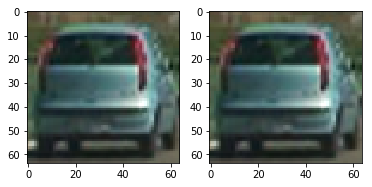

In [35]:
car_imgs = np.asarray(car_imgs)
print(type(car_imgs), car_imgs.shape)

r = car_imgs[310]
print(r.shape)
r[:,:,1]
test=mpimg.imread(carimages[310])

f=plt.figure()
plt.subplot(121)
plt.imshow(test)
plt.subplot(122)
plt.imshow(r)
plt.show()

In [36]:
car_imgs, notcar_imgs = np.asarray(car_imgs), np.asarray(notcar_imgs)
total_cars, total_notcars = car_imgs.shape[0], notcar_imgs.shape[0]
print("Total car images: {}\nTotal Non-car images: {}".format(total_cars, total_notcars))
print(car_imgs.shape)
print(notcar_imgs.shape)

Total car images: 8792
Total Non-car images: 8968
(8792, 64, 64, 3)
(8968, 64, 64, 3)


In [37]:
data_info = data_look(carimages, notcarimages)
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


In [38]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

### Generate list of Car / Non-Car Features

In [39]:

car_features, noncar_features = [], []

car_features = extract_features(car_imgs, color_space='YUV', orient=orient, pix_per_cell=pix_per_cell, cell_per_block=2, hog_channel='ALL', spatial_feat=False, hist_feat=True,hog_feat=True)

noncar_features = extract_features(notcar_imgs, color_space='YUV', orient=orient, pix_per_cell=pix_per_cell, cell_per_block=2, hog_channel='ALL', spatial_feat=False, hist_feat=True,hog_feat=True)

car_features = np.asarray(car_features)
noncar_features = np.asarray(noncar_features)

print(car_features.shape,noncar_features.shape)

(8792, 1284) (8968, 1284)


In [40]:
# Create an array stack of scaled feature vectors

unscaled_x = np.vstack((car_features, noncar_features)).astype(np.float64)
print("unscaled_x.shape: {}".format(unscaled_x.shape))
# Fit a per-column scaler
X_scaler = StandardScaler().fit(unscaled_x)
# Apply the scaler to X
scaled_X = X_scaler.transform(unscaled_x)
y = np.hstack((np.ones(len(car_features)),np.zeros(len(noncar_features))))

unscaled_x.shape: (17760, 1284)


In [41]:

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

from sklearn.svm import LinearSVC
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
print('My SVC predicts: ', svc.predict(X_test[0].reshape(1, -1)))
print('For labels: ', y_test[0])

(14208, 1284) (14208,)
(3552, 1284) (3552,)
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1284
Test Accuracy of SVC =  0.994087837838
My SVC predicts:  [ 0.]
For labels:  0.0


In [42]:
# Save SVC to pickle

from sklearn.externals import joblib
SCALER_PICKLE = 'scaler.joblib.pkl'
SCALED_X_PICKLE = 'scaled_x.joblib.pkl'
SVC_PICKLE = 'svc.joblib.pkl'

print("Starting Pickle Process...")
joblib.dump(X_scaler, SCALER_PICKLE, compress=9)
print("X_scaler pickle complete.")
joblib.dump(scaled_X, SCALED_X_PICKLE, compress=9)
print("scaled_X pickle complete.")
joblib.dump(svc, SVC_PICKLE, compress=9)
print("SVC pickle complete.")

Starting Pickle Process...
X_scaler pickle complete.
scaled_X pickle complete.
SVC pickle complete.


len(hot_windows): 4


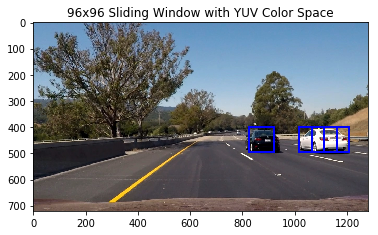

In [52]:
from functions import *
image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
# image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[200, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=True, hog_feat=True)                       
print("len(hot_windows): {}".format(len(hot_windows)))
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.title('96x96 Sliding Window with YUV Color Space')
plt.show()

Scale: 1
Scale: 1.5
Scale: 2
2 cars found


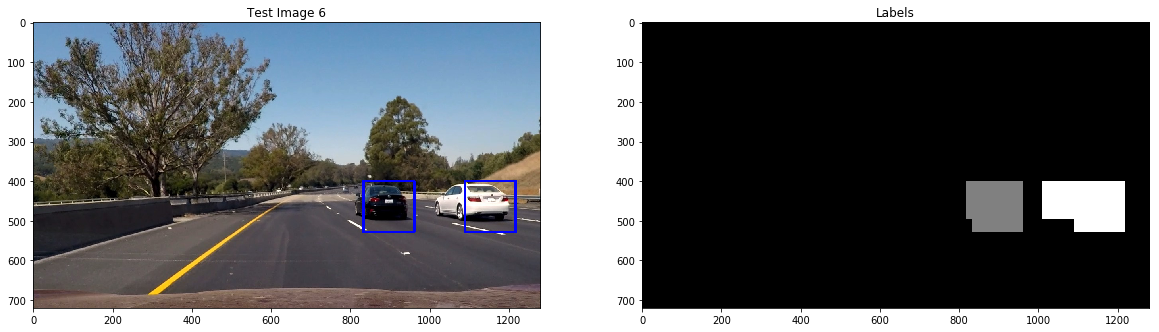

In [67]:
"""
Cycle through all test images and plot with heatmaps
"""
%matplotlib inline
from functions import *

ystart = 400
ystop = 656
scale_list = [1,1.5,2]
n = 6
image = mpimg.imread('test_images/test' + str(n) + '.jpg')

# frame_box_list = []
heat = np.zeros_like(image[:,:,0]).astype(np.float)
for scale in scale_list:
    print("Scale: {}".format(scale))
    out_img, bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
#     frame_box_list.append(bbox_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,0)
heatmap = np.clip(heat, 0, 255)

from scipy.ndimage.measurements import label
labels = label(heatmap)
# Visualize the heatmap when displaying    
print(labels[1],'cars found')
plt.figure(figsize=(20, 15))
plt.subplot(121)
plt.title('Test Image ' + str(n))
plt.imshow(out_img)
plt.subplot(122)
plt.title('Labels')
plt.imshow(labels[0],cmap='gray')
# plt.subplot(122)
# plt.title('Heatmap')
# plt.imshow(heatmap, cmap='hot')

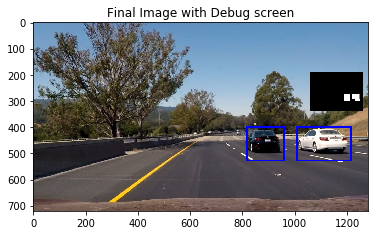

In [69]:
fig = plt.figure()
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# plt.figure(figsize=(20,15))
# plt.subplot(121)
# plt.imshow(draw_img)
# plt.subplot(122)
# plt.imshow(heatmap,cmap='hot')
resized_heatmap = 255*cv2.resize(heatmap, (200, 150), interpolation=cv2.INTER_AREA)

# Compose the 3 channel Heatmap
rgb_heatmap = cv2.merge([resized_heatmap, resized_heatmap, resized_heatmap])

# Add Heatmap to the Image
draw_img[190:340,1060:1260] = rgb_heatmap
plt.title('Final Image with Debug screen')
plt.imshow(draw_img)


In [48]:
# Video Processor Class
from functions import *
import collections
import numpy as np
from scipy.ndimage.measurements import label
from scipy.misc import imread

class VideoProcessor(object):

    def __init__(self):
        self.heatmap_que = collections.deque(maxlen=24)
#         self.frame_count = 0

    def process_frame(self, frame):
        # img = imread(frame)
        img = np.copy(frame)
        heat = np.zeros_like(img[:,:,0]).astype(np.float)

        ystart = 400
        ystop = 656
        # scale = 1
        scale_list = [1,1.5,2]
#         print(' --- NEW FRAME --- ')
        frame_box_list = []
        for scale in scale_list:
            out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            # Add heat to each box in box list
#             print("scale: {}".format(scale))
#             for box in bbox_list:
            
#                 print("box  in bbox list: {}".format(box))
            heat = add_heat(heat, bbox_list)

        self.heatmap_que.append(heat)
        heat = (sum(self.heatmap_que))
#         print(np.amax(self.heatmap_que))
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,13)
        heatmap = np.clip(heat, 0, 255) 
        labels = label(heatmap)
        
        resized_heatmap = 255*cv2.resize(heatmap, (200, 150), interpolation=cv2.INTER_AREA)

        # Compose the 3 channel Heatmap
        rgb_heatmap = cv2.merge([resized_heatmap, resized_heatmap, resized_heatmap])

        draw_img = draw_labeled_bboxes(img, labels)
        # Add Heatmap to the Image
        draw_img[190:340,1060:1260] = rgb_heatmap
#         self.frame_count = self.frame_count + 1
#         print(self.frame_count)
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         cv2.putText(draw_image,str(self.frame_count),(400,50), font, 1,(255,255,255),2,cv2.LINE_AA)
        return draw_img

    def add_frame_boxes(self, bboxes):
        self.bounding_boxes_list.append(bboxes)

    def get_box_list(self):
        return self.bounding_boxes_list

        # heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    def compute_heatmap(self, heatmap):
        for box in self.bounding_boxes_list:
            print(box[0][1])
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        # self.apply_threshold(heatmap, averaged_frames=10)
        return heatmap

    @staticmethod
    def apply_threshold(heatmap, averaged_frames=10, threshold=2):
        heatmap[heatmap <= threshold] = 0
        return heatmap

In [49]:
# vid_processor = VideoProcessor()
# output1 = 'output_images/left_check3.mp4'
# clip1 = VideoFileClip("super_short.mp4")
# white_clip = clip1.fl_image(vid_processor.process_frame) #NOTE: this function expects color images!!
# white_clip.write_videofile(output1, audio=False)


In [50]:
# vid_processor = VideoProcessor()
# output1 = 'output_images/combined_output.mp4'
# clip1 = VideoFileClip("P4_video.mp4")
# white_clip = clip1.fl_image(vid_processor.process_frame) #NOTE: this function expects color images!!
# white_clip.write_videofile(output1, audio=False)


In [51]:
vid_processor = VideoProcessor()
output1 = 'output_images/P5_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(vid_processor.process_frame) #NOTE: this function expects color images!!
white_clip.write_videofile(output1, audio=False)


[MoviePy] >>>> Building video output_images/P5_output.mp4
[MoviePy] Writing video output_images/P5_output.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:00<11:16,  1.86it/s]



  0%|          | 2/1261 [00:01<11:19,  1.85it/s]



  0%|          | 3/1261 [00:01<11:20,  1.85it/s]



  0%|          | 4/1261 [00:02<11:18,  1.85it/s]



  0%|          | 5/1261 [00:02<11:11,  1.87it/s]



  0%|          | 6/1261 [00:03<11:11,  1.87it/s]



  1%|          | 7/1261 [00:03<11:17,  1.85it/s]



  1%|          | 8/1261 [00:04<11:35,  1.80it/s]


  1%|          | 9/1261 [00:04<11:32,  1.81it/s]


  1%|          | 10/1261 [00:05<11:26,  1.82it/s]


  1%|          | 11/1261 [00:06<11:25,  1.82it/s]


  1%|          | 12/1261 [00:06<11:30,  1.81it/s]


  1%|          | 13/1261 [00:07<11:19,  1.84it/s]


  1%|          | 14/1261 [00:07<11:12,  1.85it/s]


  1%|          | 15/1261 [00:08<11:19,  1.83it/s]


  1%|▏         | 16/1261 [00:08<11:27,  1.81it/s]


  1%|▏         | 17/1261 [00:09<11:23,  1.82it/s]


  1%|▏         | 18/1261 [00:09<11:36,  1.78it/s]


  2%|▏         | 1

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/P5_output.mp4 

